# Exploratory Data Analysis

The goal of this project is to develop recommendation systems for the Food.com dataset (Majumder et al. 2019) available on Kaggle. The aim of this EDA is to determine which features will be useful for understanding user preferences, learn about the characteristics of the dataset, identify insights and peculiarities, and help me start thinking about feature engineering.

### Load Data

#### Import Libraries

In [1]:
import ast
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from textblob import TextBlob

In [2]:
# Define data location
RAW_DATA_PATH = r"..\data\raw"
RECIPES_FILE = "RAW_recipes.csv"
INTERACTIONS_FILE = "RAW_interactions.csv"

recipes_path = os.path.join(RAW_DATA_PATH, RECIPES_FILE)
interactions_path = os.path.join(RAW_DATA_PATH, INTERACTIONS_FILE)

In [3]:
# Initial data import
recipes = pd.read_csv(recipes_path)
interactions = pd.read_csv(interactions_path)

#### Inspect initial format

In [4]:
recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [5]:
interactions.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


#### Basic transforms
From the above, I can identify a few simple transforms that will assist in EDA. Date formats will allow plotting trends, and there are a number of columns that contain lists of values, which can be stored in the DataFrame. Finally, the removal of newlines in text fields will help with future NLP tasks and parsing if the data is later exported or converted


In [6]:
# Convert dates
recipes["submitted"] = pd.to_datetime(recipes["submitted"], format="%Y-%m-%d")
interactions["date"] = pd.to_datetime(interactions["date"], format="%Y-%m-%d")

# Remove special characters from text fields
recipes["description"] = recipes["description"].str.replace("\r\n", " ")
recipes["description"] = recipes["description"].str.replace("\n", " ")
interactions["review"] = interactions["review"].str.replace("\r\n", " ")
interactions["review"] = interactions["review"].str.replace("\n", " ")

# Cast list-like columns explicitly into lists
list_like_columns = ["tags", "nutrition", "steps", "ingredients"]
recipes[list_like_columns] = recipes[list_like_columns].applymap(ast.literal_eval)

# Separate values in the nutrition column into their own columns
NUTRITION_COLS = ["calories", "total_fat_pdv", "sugar_pdv", "sodium_pdv", "protein_pdv", "saturated_fat_pdv", "carbohydrates_pdv"]
recipes[NUTRITION_COLS] = pd.DataFrame(recipes["nutrition"].tolist(), index=recipes.index)
recipes.drop("nutrition", inplace=True, axis=1)

In [7]:
# Check the new schemas and count null values
recipes.info()
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   name               231636 non-null  object        
 1   id                 231637 non-null  int64         
 2   minutes            231637 non-null  int64         
 3   contributor_id     231637 non-null  int64         
 4   submitted          231637 non-null  datetime64[ns]
 5   tags               231637 non-null  object        
 6   n_steps            231637 non-null  int64         
 7   steps              231637 non-null  object        
 8   description        226658 non-null  object        
 9   ingredients        231637 non-null  object        
 10  n_ingredients      231637 non-null  int64         
 11  calories           231637 non-null  float64       
 12  total_fat_pdv      231637 non-null  float64       
 13  sugar_pdv          231637 non-null  float64 

### Analysis
#### Descriptive stats for numeric values

In [8]:
NUMERIC_COLS = ["minutes", "submitted", "n_steps", "n_ingredients", "calories", "total_fat_pdv", "sugar_pdv", "sodium_pdv", "protein_pdv", "saturated_fat_pdv", "carbohydrates_pdv"]
recipes[NUMERIC_COLS].describe()

,minutes,submitted,n_steps,n_ingredients,calories,total_fat_pdv,sugar_pdv,sodium_pdv,protein_pdv,saturated_fat_pdv,carbohydrates_pdv
count,2.316370e+05,231637,231637.000000,231637.000000,231637.000000,231637.00000,231637.000000,231637.000000,231637.00000,231637.000000,231637.000000
mean,9.398546e+03,2006-11-14 01:58:34.925508096,9.765499,9.051153,473.942425,36.08070,84.296865,30.147485,34.68186,45.589150,15.560403
min,0.000000e+00,1999-08-06 00:00:00,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,2.000000e+01,2004-09-16 00:00:00,6.000000,6.000000,174.400000,8.00000,9.000000,5.000000,7.00000,7.000000,4.000000
50%,4.000000e+01,2007-01-23 00:00:00,9.000000,9.000000,313.400000,20.00000,25.000000,14.000000,18.00000,23.000000,9.000000
75%,6.500000e+01,2008-10-29 00:00:00,12.000000,11.000000,519.700000,41.00000,68.000000,33.000000,51.00000,52.000000,16.000000
max,2.147484e+09,2018-12-04 00:00:00,145.000000,43.000000,434360.200000,17183.00000,362729.000000,29338.000000,6552.00000,10395.000000,36098.000000
std,4.461963e+06,NaN,5.995128,3.734796,1189.711374,77.79884,800.080897,131.961589,58.47248,98.235758,81.824560


In [9]:
interactions[["date","rating"]].describe()

,date,rating
count,1132367,1.132367e+06
mean,2009-05-13 02:57:38.777586944,4.411016e+00
min,2000-01-25 00:00:00,0.000000e+00
25%,2007-03-11 00:00:00,4.000000e+00
50%,2008-12-29 00:00:00,5.000000e+00
75%,2011-03-07 00:00:00,5.000000e+00
max,2018-12-20 00:00:00,5.000000e+00
std,NaN,1.264752e+00


#### Examine outliers

In [10]:
outlier_fields = ["minutes", "calories", "total_fat_pdv", "sugar_pdv", "sodium_pdv", "protein_pdv", "saturated_fat_pdv", "carbohydrates_pdv"]
for field in outlier_fields:
    print(f"Top values for {field}:")
    print(recipes[field].nlargest(10),"\n")

Top values for minutes:
144074    2147483647
109624       1051200
106563        288000
38116         259260
106963        259205
155044        216015
5497          201610
177906        187200
170999        172810
53721         172800
Name: minutes, dtype: int64 

Top values for calories:
209453    434360.2
70467     101614.7
165504     45609.0
137181     44239.8
34023      43924.6
141997     42951.6
78689      40159.2
182816     38680.1
199615     38662.3
139058     36188.8
Name: calories, dtype: float64 

Top values for total_fat_pdv:
70467     17183.0
199615     4331.0
182816     4317.0
56433      3464.0
165504     3379.0
84023      3229.0
164719     3105.0
102405     3072.0
134453     3021.0
219494     2899.0
Name: total_fat_pdv, dtype: float64 

Top values for sugar_pdv:
209453    362729.0
139058     30260.0
34023      18943.0
107018     18127.0
137181     17306.0
165504     16901.0
95612      14495.0
105817     13573.0
931        12914.0
187719     11042.0
Name: sugar_pdv, dtype: 

A few quick takeaways:

* The data seems nicely distributed over time; user interactions trail recipes submissions as expected
* Ratings distribution is skewed in a typical manner, i.e. high ratings are much more common
* The minutes field and nutritional fields have significant outliers that skew the mean
    * Upon inspection of some recipes pages, the ones with the highest nutrition values are mostly large bulk specialty recipes (e.g., brewing large quantities of whiskey). These will be kept for now
    * There are a few outliers in the minutes field, but the top value (2^31 minutes, or about 4000 years) seems to be a scraping error. The next value is also significant larger than the rest and is from a joke recipe that can be removed from the dataset. The third-highest value of 288000 minutes (~6 months) is for brewing liquers, which is reasonable and less of an anomaly compared to the others. This value will be retained as the new upper limit.

In [11]:
# Correct minutes outlier
recipes.at[144074, "minutes"] = 25

# Drop the joke recipe
joke_id = recipes.at[109624, "id"]
interactions = interactions[interactions["recipe_id"] != joke_id]
recipes.drop(109624, inplace=True)

#### Basic Univariate Distributions

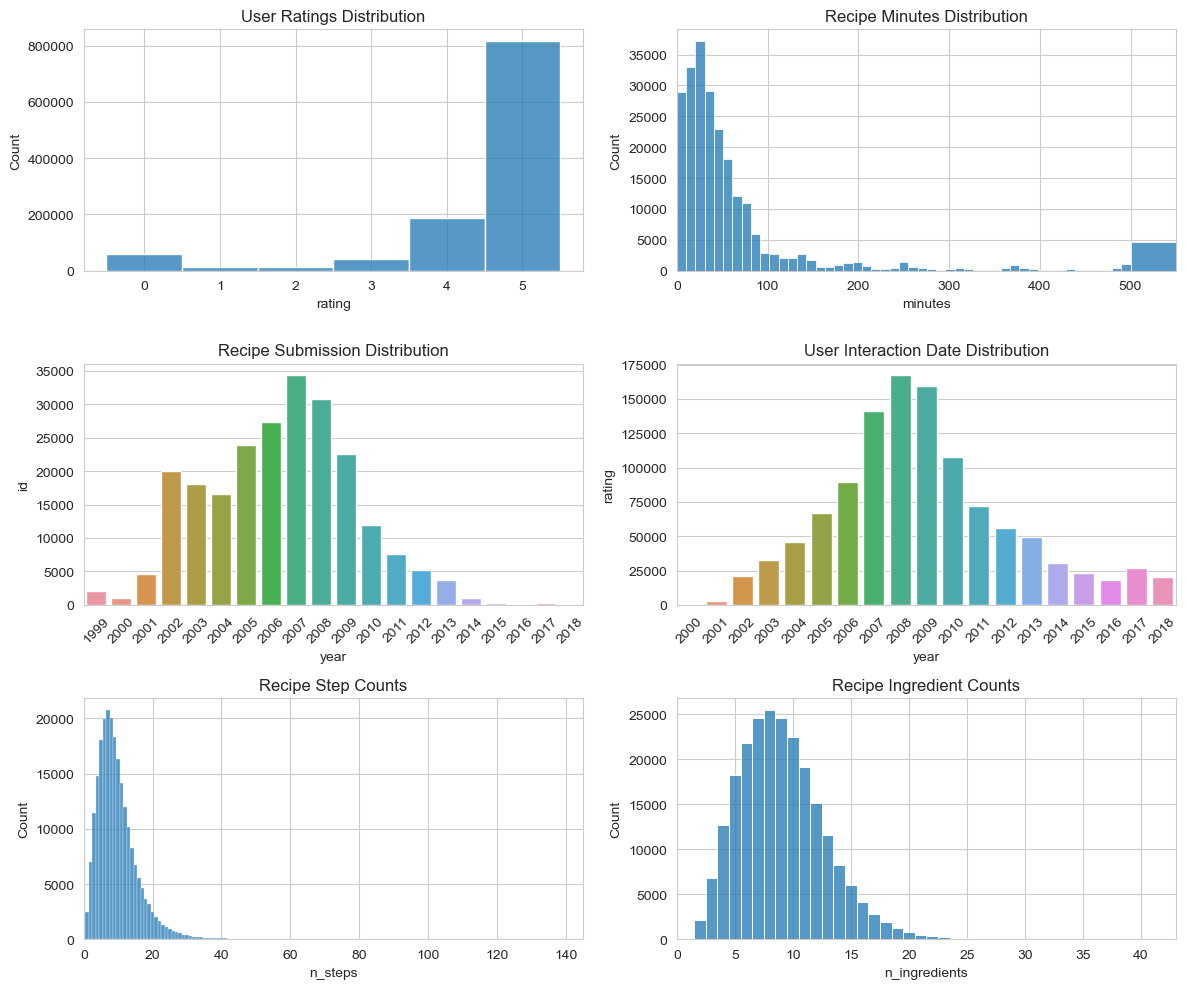

In [12]:
sns.set_style("whitegrid")

plt.figure(figsize=(12, 10))

plt.subplot(3, 2, 1)
plt.title("User Ratings Distribution")
sns.histplot(interactions["rating"], discrete=True)

plt.subplot(3, 2, 2)
plt.title("Recipe Minutes Distribution")
edges = np.linspace(recipes.minutes.min(), 500, 50)
edges = np.append(edges, recipes.minutes.max())
plt.xlim([0,550])
sns.histplot(recipes["minutes"], bins=edges)

plt.subplot(3, 2, 3)
plt.title("Recipe Submission Distribution")
dates = recipes[["submitted", "id"]].set_index("submitted")
date_counts = dates.resample("Y").count()
date_counts.reset_index(inplace=True)
date_counts["year"] = date_counts["submitted"].dt.strftime("%Y")
sns.barplot(x=date_counts["year"], y=date_counts["id"])
plt.xticks(rotation=45) 

plt.subplot(3, 2, 4)
plt.title("User Interaction Date Distribution")
dates = interactions[["date","rating"]].set_index("date")
date_counts = dates.resample('Y').count()
date_counts.reset_index(inplace=True)
date_counts["year"] = date_counts["date"].dt.strftime("%Y")
sns.barplot(x=date_counts["year"], y=date_counts["rating"])
plt.xticks(rotation=45) 

plt.subplot(3, 2, 5)
plt.title("Recipe Step Counts")
plt.xlim([0,recipes["n_steps"].max()])
sns.histplot(recipes["n_steps"], discrete=True)

plt.subplot(3, 2, 6)
plt.title("Recipe Ingredient Counts")
plt.xlim([0,recipes["n_ingredients"].max()])
sns.histplot(recipes["n_ingredients"], discrete=True)

plt.tight_layout()
plt.show()

Observations:
* The previous observation of skewed ratings does indeed seem true
    * Ratings of zero are for reviews or comments without ratings, and do not necessarily reflect a poor (or any) opinion
* The minutes distribution has a very long tail
* The time distribution of reviews lags those of recipes, as expected, and there are also more reviews than recipes
* Recipes and ingredients have lognormal-like distributions with reasonable tail values

#### Bivariate Analysis

In [13]:
# Join average ratings to recipe data
recipe_ratings = interactions.groupby("recipe_id")["rating"].agg(["mean", "count"]).reset_index()
recipes= pd.merge(recipes, recipe_ratings, "inner", left_on="id", right_on="recipe_id")
recipes.rename(columns={"mean": "average_rating", "count": "interaction_count"}, inplace=True)
recipes.drop("recipe_id", axis=1, inplace=True)
NUMERIC_COLS += ["average_rating", "interaction_count"]

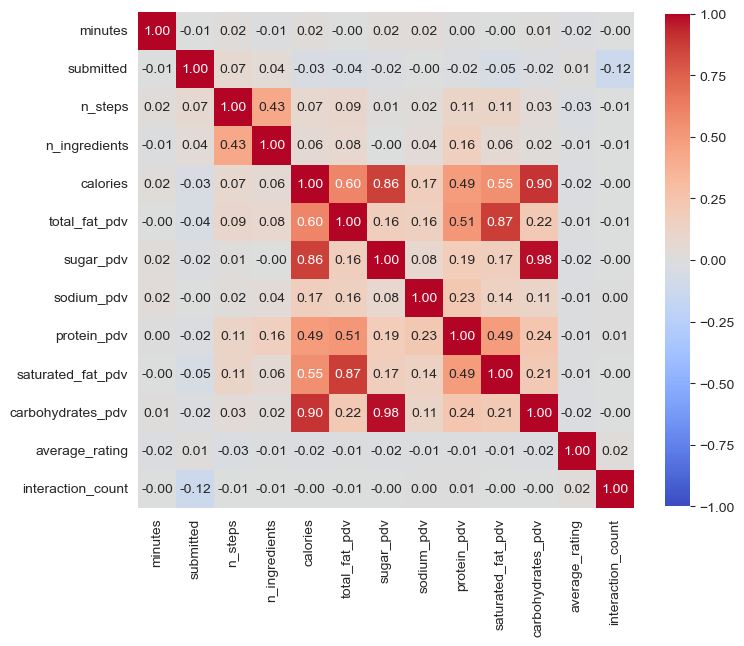

In [14]:
""# Start with correlation
corr = recipes[NUMERIC_COLS].corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, square=True, cbar_kws={"shrink": 0.8}, fmt=".2f")
plt.show()

Most of the fields are not strongly correlated, except for the nutritional values. A positive correlation of calories with protein, fat, sugar, and carbs is expected (particularly in the case of the latter three). The relationship between sodium and calories is much weaker, because sodium does not contribute to caloric content. The other correlation of note is one between the number of recipe steps and ingredients.

It's worth noting that there is _not_ a clear relationship between the 'submitted' field and any others, indicating the lack of a long-term trend in the other fields. The exception is with interaction count, which is understandable as older recipes will have had more time to accrue interactions. There is also no meaningful correlation between the average rating of a recipe and any of the other features.

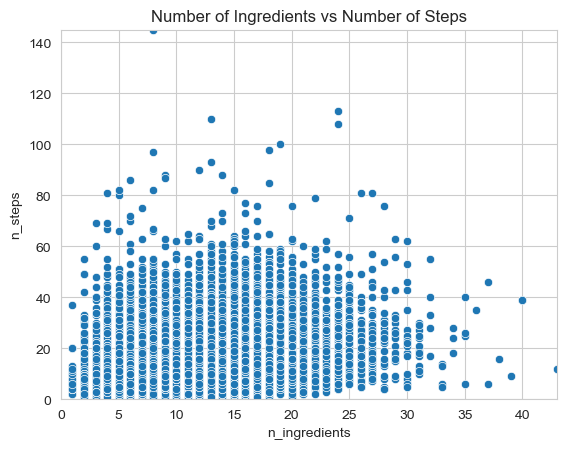

In [15]:
# Examine relationship between ingredients and steps
sns.scatterplot(x=recipes["n_ingredients"], y=recipes["n_steps"])
plt.title("Number of Ingredients vs Number of Steps")
plt.xlim([0,recipes["n_ingredients"].max()])
plt.ylim([0,recipes["n_steps"].max()])
plt.show()

There is also not a strong correlation between minutes and the number of steps or the number of ingredients, which is surprising. Let's investigate:

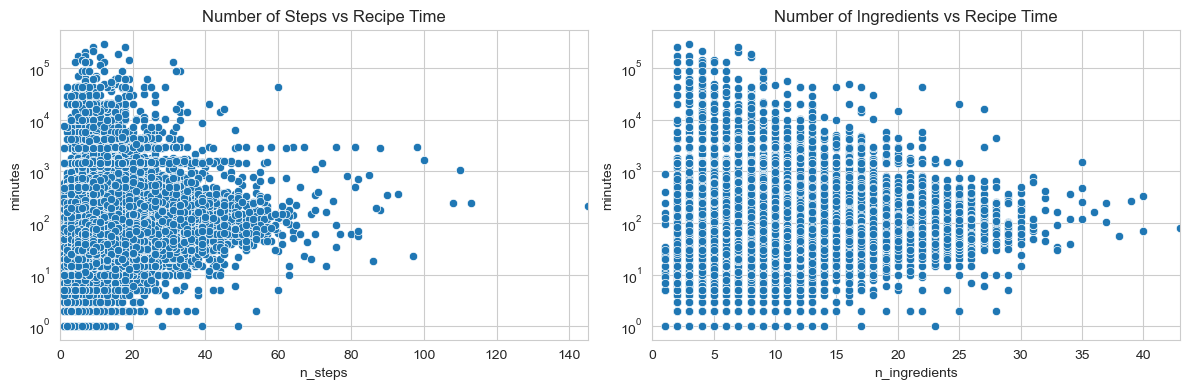

In [16]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.scatterplot(x=recipes["n_steps"], y=recipes["minutes"])
plt.title("Number of Steps vs Recipe Time")
plt.xlim([0,recipes["n_steps"].max()])
plt.yscale("log")

plt.subplot(1, 2, 2)
sns.scatterplot(x=recipes["n_ingredients"], y=recipes["minutes"])
plt.title("Number of Ingredients vs Recipe Time")
plt.xlim([0,recipes["n_ingredients"].max()])
plt.yscale("log")

plt.tight_layout()
plt.show()

It looks like the intuitive positive relationship could potentially exist, but very high values of the minutes field throw this off and also make it difficult to determine visually. Also, recipes with high counts of ingredients and steps seem to have surprisingly low completion times in some cases. It is possible that the minutes field is less reliable than others due to its subjective and highly variable nature.

## Analysis of Text Data
#### Ingredients and Tags

Total number of ingredients with interactions: 14942

Most Common Ingredients:
         ingredients      mean  count
11751           salt  4.315016  85746
1651          butter  4.337297  54975
12908          sugar  4.290884  44535
9414           onion  4.335771  39065
14316          water  4.248465  34914
4453            eggs  4.271137  33761
9397       olive oil  4.406750  32822
4941           flour  4.246655  26266
8727            milk  4.268760  25786
5692   garlic cloves  4.376648  25748


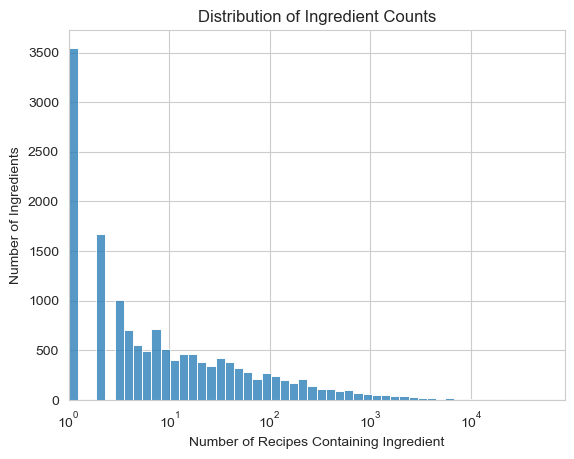

Median number of recipes containing an ingredient:
5.0


In [17]:
# Examine properties of individual ingredients
ingredient_recipe_avg_ratings = recipes[["ingredients", "average_rating"]].explode("ingredients")
ingredient_avg_ratings = ingredient_recipe_avg_ratings.groupby("ingredients")["average_rating"].agg(["mean", "count"]).reset_index()
n_unique_ingredients = ingredient_recipe_avg_ratings["ingredients"].nunique()
print(f"Total number of ingredients with interactions: {n_unique_ingredients}\n")

print("Most Common Ingredients:")
ingredient_avg_ratings.sort_values(by=["count", "mean"], ascending=False, inplace=True)
print(ingredient_avg_ratings.head(10))

plt.title("Distribution of Ingredient Counts")
plt.xlabel("Number of Recipes Containing Ingredient")
plt.ylabel("Number of Ingredients")
plt.xscale("log")
plt.xlim([1,ingredient_avg_ratings["count"].max()])
sns.histplot(ingredient_avg_ratings["count"])
plt.show()

print(f"Median number of recipes containing an ingredient:\n{ingredient_avg_ratings['count'].median()}")

It appears that most ingredients are extremely rare, with half of them only appearing in five or fewer recipes. The average rating for such ingredients will be less reliable due to small sample size. The Bayesian average will serve as a more useful indicator for top ingredients.

In [18]:
# Calculate Bayesian average for ingredient ratings
avg_recipes_per_ingredient = ingredient_avg_ratings["count"].mean()
avg_ingredient_rating = ingredient_avg_ratings["mean"].mean()
print(f"Avg ingredient rating: {avg_ingredient_rating}")
print(f"Avg ingredient count: {avg_recipes_per_ingredient}\n")

ingredient_avg_ratings["bayesian_avg"] = ((avg_recipes_per_ingredient * avg_ingredient_rating) + (ingredient_avg_ratings["count"] * ingredient_avg_ratings["mean"])) / (avg_recipes_per_ingredient + ingredient_avg_ratings["count"])

print("Top Ingredients:")
ingredient_avg_ratings.sort_values(by=["bayesian_avg", "count"], ascending=False, inplace=True)
print(ingredient_avg_ratings.head(10),'\n')

print("Bottom Ingredients:")
ingredient_avg_ratings.sort_values(by=["bayesian_avg", "count"], ascending=True, inplace=True)
print(ingredient_avg_ratings.head(10))

Avg ingredient rating: 4.30920242274743
Avg ingredient count: 140.3145495917548

Top Ingredients:
              ingredients      mean  count  bayesian_avg
3402      cranberry juice  4.590908    606      4.537945
8895   mixed salad greens  4.647400    284      4.535563
4788          feta cheese  4.537116   2510      4.525050
14002   vanilla ice cream  4.549372   1164      4.523535
7215               kahlua  4.570600    565      4.518597
10688          prosciutto  4.561367    675      4.517970
11576     romaine lettuce  4.546963    993      4.517526
5792           ginger ale  4.586923    420      4.517376
7224      kalamata olives  4.587714    382      4.512895
4484     english cucumber  4.604133    300      4.510148 

Bottom Ingredients:
                  ingredients      mean  count  bayesian_avg
12760                  stevia  3.502381     89      3.996064
12930        sugar substitute  3.870764    284      4.015749
11427              rice flour  3.941905    399      4.037465
1775     

Subjectively, the top ingredients seem to make sense. Additionally, none of the ingredients are very uncommon. There is no strong over-arching theme to these ingredients, except maybe that a few of them are healthy, or indicative of luxury. In contrast, the bottom ingredients are all food substitutes or additives.

Total number of tags with interactions: 552

Most Common Tags:
                 tags      mean   count
400       preparation  4.346528  230545
516      time-to-make  4.349263  225325
133            course  4.347367  218147
297   main-ingredient  4.359346  170446
155           dietary  4.338228  165090
165              easy  4.361330  126061
345          occasion  4.351027  114145
142           cuisine  4.344516   91165
284  low-in-something  4.343427   85775
291         main-dish  4.324567   71785


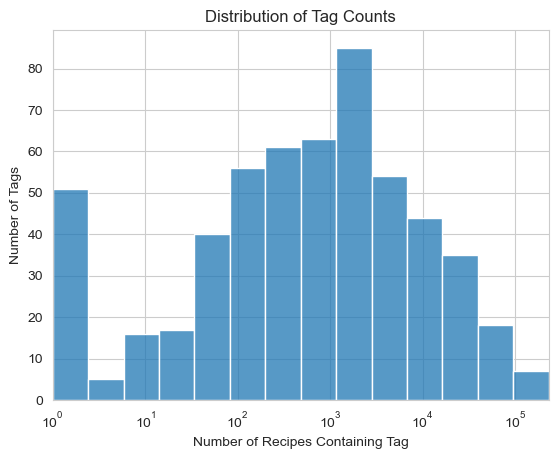

Median number of recipes containing a tag:
757.5


In [19]:
# Same process for tags
tag_recipe_avg_ratings = recipes[["tags", "average_rating"]].explode("tags")
tag_avg_ratings = tag_recipe_avg_ratings.groupby("tags")["average_rating"].agg(["mean", "count"]).reset_index()
n_unique_tags = tag_recipe_avg_ratings["tags"].nunique()
print(f"Total number of tags with interactions: {n_unique_tags}\n")

print("Most Common Tags:")
tag_avg_ratings.sort_values(by=["count","mean"], ascending=False, inplace=True)
print(tag_avg_ratings.head(10))

plt.title("Distribution of Tag Counts")
plt.xlabel("Number of Recipes Containing Tag")
plt.ylabel("Number of Tags")
plt.xscale("log")
plt.xlim([1,tag_avg_ratings["count"].max()])
sns.histplot(tag_avg_ratings["count"])
plt.show()

print(f"Median number of recipes containing a tag:\n{tag_avg_ratings['count'].median()}")

Although there are far fewer tags than ingredients, and the distribution is considerably less skewed (closer to lognormal), the frequency of tags still spans several orders of magnitude. As a result, it is worth looking at the Bayesian average here as well. This should also help normalize low-information tags (e.g., "course", "time-to-make") that are artefacts of the scraping process. The tags are in the recipe web page URL and not surfaced to end-users.

In [20]:
# Calculate Bayesian average for tag ratings
avg_recipes_per_tag = tag_avg_ratings["count"].mean()
avg_tag_rating = tag_avg_ratings["mean"].mean()
print(f"Avg tag rating: {avg_tag_rating}")
print(f"Avg tag count: {avg_recipes_per_tag}\n")

tag_avg_ratings["bayesian_avg"] = ((avg_recipes_per_tag * avg_tag_rating) + (tag_avg_ratings["count"] * tag_avg_ratings["mean"])) / (avg_recipes_per_tag + tag_avg_ratings["count"])

print("Top Tags:")
tag_avg_ratings.sort_values(by=["bayesian_avg", "count"], ascending=False, inplace=True)
print(tag_avg_ratings.head(10),'\n')

print("Bottom Tags:")
tag_avg_ratings.sort_values(by=["bayesian_avg", "count"], ascending=True, inplace=True)
print(tag_avg_ratings.head(10))

Avg tag rating: 4.286313546281486
Avg tag count: 7503.032608695652

Top Tags:
                   tags      mean  count  bayesian_avg
49            beverages  4.532839  11124      4.433538
433              salads  4.498711  14687      4.426894
2    15-minutes-or-less  4.421490  43934      4.401772
500              summer  4.457623  10039      4.384351
188          for-1-or-2  4.414892  23083      4.383351
3       3-steps-or-less  4.398304  44933      4.382279
118           cocktails  4.537123   4310      4.377822
156        dinner-party  4.396042  37561      4.377773
531          vegetables  4.388604  53814      4.376087
457         side-dishes  4.400588  26902      4.375667 

Bottom Tags:
                      tags      mean  count  bayesian_avg
130                copycat  3.995970   2314      4.217876
77                   cakes  4.171178   9653      4.221531
338                novelty  4.136260   4632      4.229038
139  crock-pot-slow-cooker  4.175806   6608      4.234564
128   cookie

The top recipes based on tags are varied, but there are multiple describing recipes which are quick or simple, as well as drinks. The bottom recipes surprisingly describe several desserts, which might be related to the unpopular sugar and flour substitutes discovered previously. 

Though the rating distribution between ingredients and tags looks different, it is clear that __both__ have a clear relationship on ratings.

#### Word Counts

In [21]:
# Count words in recipe fields
recipes["description_word_count"] = recipes["description"].str.split().str.len()

recipes["steps_word_count"] = recipes["steps"].apply(lambda x: sum([len(step.split()) for step in x]))
recipes["avg_step_word_count"] = recipes["steps_word_count"] / recipes["n_steps"]

WORD_COUNT_COLS = ["steps_word_count", "avg_step_word_count", "description_word_count"]
NUMERIC_COLS += WORD_COUNT_COLS

# Descriptive stats on new columns
recipes[WORD_COUNT_COLS].describe()

,steps_word_count,avg_step_word_count,description_word_count
count,231636.000000,231635.000000,226657.000000
mean,102.081455,10.422034,36.385689
std,73.948741,3.526212,32.226114
min,0.000000,1.000000,0.000000
25%,54.000000,8.000000,15.000000
50%,86.000000,10.000000,28.000000
75%,130.000000,12.250000,48.000000
max,2246.000000,150.000000,1168.000000


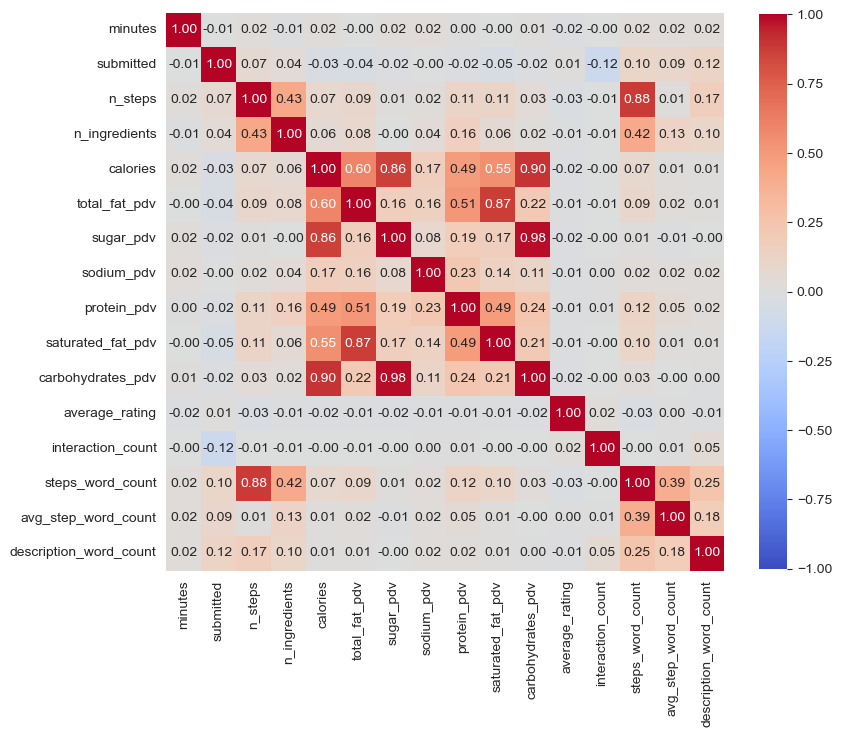

In [22]:
# Examine correlations
corr = recipes[NUMERIC_COLS].corr()
plt.figure(figsize=(9,9))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, square=True, cbar_kws={"shrink": 0.8}, fmt='.2f')
plt.show()

A few new correlations emerge here. The highest one, between step word count (across all steps) and the number of steps, is trivial. However, there are a few others:
* Total step word counts and average step word counts are positively correlated, suggesting that longer instructions in total also lead to longer instructions per step
* The description word count is correlated to the number of steps and ingredients, as well as the average and total step word count
* These correlations are weak, but they aren't necessarily negligible either

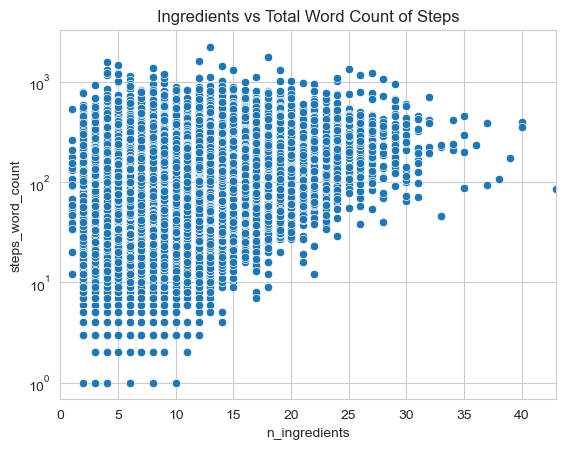

In [23]:
# Examine ingredients and word count graphically
plt.title("Ingredients vs Total Word Count of Steps")
sns.scatterplot(x=recipes["n_ingredients"], y=recipes["steps_word_count"])
plt.xlim([0,recipes["n_ingredients"].max()])
plt.yscale("log")
plt.show()

Correlation between review word count and rating:
0.015690493656766755


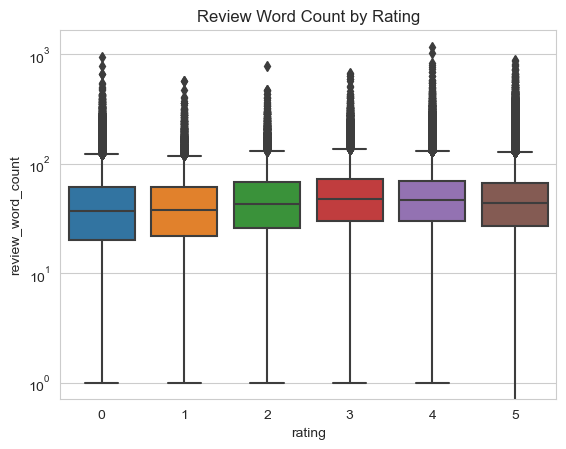

In [24]:
# Count words in reviews
interactions["review_word_count"] = interactions["review"].str.split().str.len()

print("Correlation between review word count and rating:")
print(interactions[["review_word_count", "rating"]].corr().iloc[0, 1])

plt.title("Review Word Count by Rating")
sns.boxplot(x=interactions["rating"], y=interactions["review_word_count"])
plt.yscale("log")
plt.show()

It doesn't appear that the length of an individual review has much of an influence on its corresponding rating. A "U-shaped" distribution with longer reviews for both high and low rating (but a low linear correlation) is also absent. However, it is possible that there is a relationship between average review length of a recipe and other recipe properties. 

In [25]:
# Calculate average review length by recipe and join
recipe_reviews = interactions.groupby("recipe_id")["review_word_count"].mean().reset_index()
recipes= pd.merge(recipes, recipe_reviews, "inner", left_on="id", right_on="recipe_id")
recipes.drop("recipe_id", axis=1, inplace=True)

WORD_COUNT_COLS.append("review_word_count")
NUMERIC_COLS.append("review_word_count")

recipes[WORD_COUNT_COLS].describe()

,steps_word_count,avg_step_word_count,description_word_count,review_word_count
count,231636.000000,231635.000000,226657.000000,231629.000000
mean,102.081455,10.422034,36.385689,53.680937
std,73.948741,3.526212,32.226114,30.019055
min,0.000000,1.000000,0.000000,1.000000
25%,54.000000,8.000000,15.000000,35.272727
50%,86.000000,10.000000,28.000000,49.000000
75%,130.000000,12.250000,48.000000,65.500000
max,2246.000000,150.000000,1168.000000,784.000000


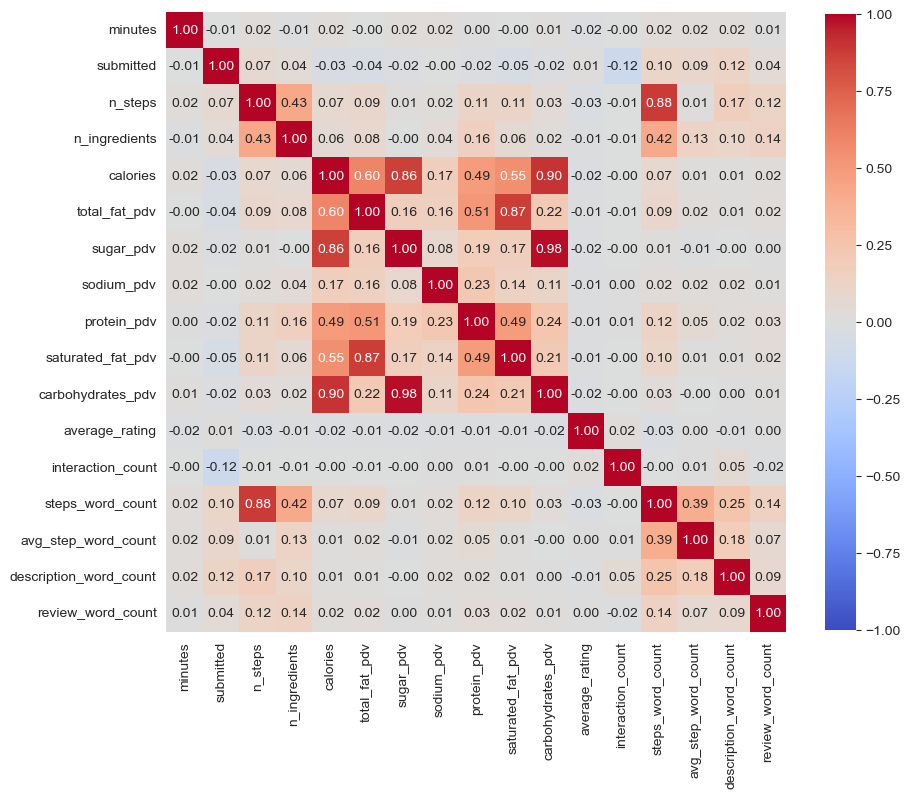

In [26]:
# Examine correlations
corr = recipes[NUMERIC_COLS].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, square=True, cbar_kws={"shrink": 0.8}, fmt='.2f')
plt.show()

Like the other word counts, the average word count of reviews also has a weak correlation to steps and ingredients; combined these could possibly indicate some measure of recipe complexity. There are also even weaker correlations to the other word count fields. As shown before, review length does not correspond to recipe rating.

#### Sentiment Analysis

In [27]:
# Define a simple function to compute sentiment using TextBlob
def score_sentiment(input_text: str = ""):
    try:
        return TextBlob(input_text).sentiment.polarity
    except TypeError:
        return None

In [28]:
# Calculate review sentiment and check for correlation
interactions['review_sentiment'] = interactions["review"].apply(score_sentiment)

print("Correlation between review sentiment and rating:")
print(interactions[["review_sentiment", "rating"]].corr().iloc[0, 1])

Correlation between review sentiment and rating:
0.20762562852719824


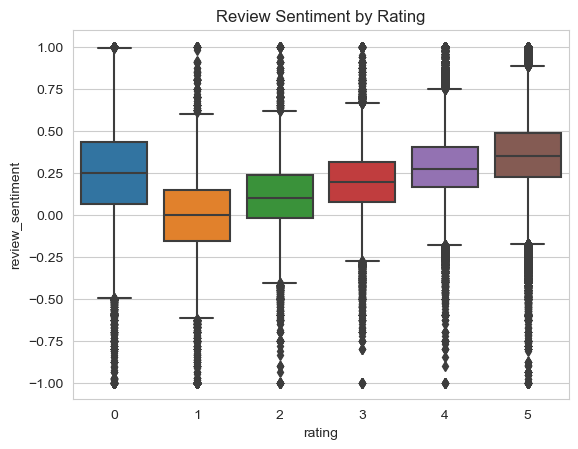

In [29]:
# Examine the plot
plt.title("Review Sentiment by Rating")
sns.boxplot(x=interactions["rating"], y=interactions["review_sentiment"])
plt.show()

As expected, there is a correlation between sentiment and rating. The correlation coefficient would be even higher if review scores of zero (indicating the recipe was tried or reviewed by the user) were handled separately. Truthfully, this is the case with all correlations to the rating, although none of the previously discussed features showed even a weak relationship with rating.

Finally, average sentiment can be examined alongside the other properties of the recipes. Sentiment is unlikely to manifest meaningfully in recipe steps, tags, or ingredients, but the sentiment of a recipe description may have some meaning.

In [30]:
# Calculate average recipe sentiment and join
recipe_sentiments = interactions.groupby("recipe_id")["review_sentiment"].mean().reset_index()
recipes= pd.merge(recipes, recipe_sentiments, "inner", left_on="id", right_on="recipe_id")
recipes.drop("recipe_id", axis=1, inplace=True)

In [31]:
# Also calculate description sentiment and describe the new fields
recipes['description_sentiment'] = recipes["description"].apply(score_sentiment)

SENTIMENT_COLS = ["description_sentiment", "review_sentiment"]
NUMERIC_COLS += SENTIMENT_COLS
recipes[SENTIMENT_COLS].describe()

,description_sentiment,review_sentiment
count,226657.000000,231629.000000
mean,0.281319,0.323601
std,0.271146,0.173436
min,-1.000000,-1.000000
25%,0.074242,0.226481
50%,0.266667,0.321094
75%,0.448611,0.413244
max,1.000000,1.000000


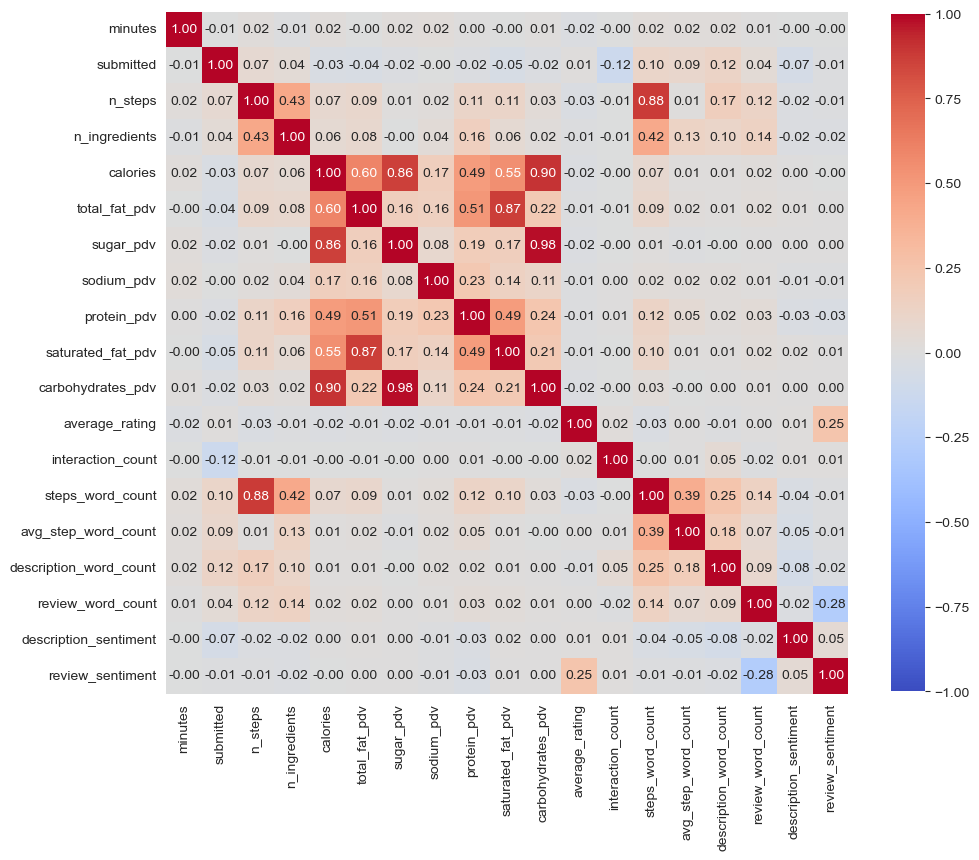

In [32]:
# Examine correlations
corr = recipes[NUMERIC_COLS].corr()
plt.figure(figsize=(11,11))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, square=True, cbar_kws={"shrink": 0.8}, fmt='.2f')
plt.show()

The relationship between review sentiment and rating carries through here as well, but an interesting new correlation appears to suggest that users write less about recipes with higher sentiment. Description sentiment does not seem to correlate strongly with any of the other fields, although the same phenomenon can be seen here to a lesser extent. Because the average review length and average sentiment are derived from the same field, it is better to examine this relationship at the interaction level.

Correlation between review word count and sentiment:
-0.27732675656302186


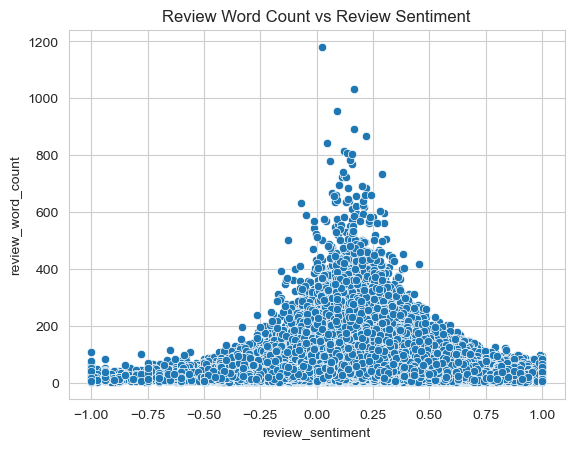

In [33]:
print("Correlation between review word count and sentiment:")
print(interactions[["review_word_count", "review_sentiment"]].corr().iloc[0, 1])

plt.title("Review Word Count vs Review Sentiment")
sns.scatterplot(y=interactions["review_word_count"], x=interactions["review_sentiment"])
plt.show()

This uncovers a very interesting pattern. Users write longer reviews for neutral-sentiment reviews. There is not much deviation from this pattern either. However, it is difficult to discern frequency due to the high degree of data overlap.

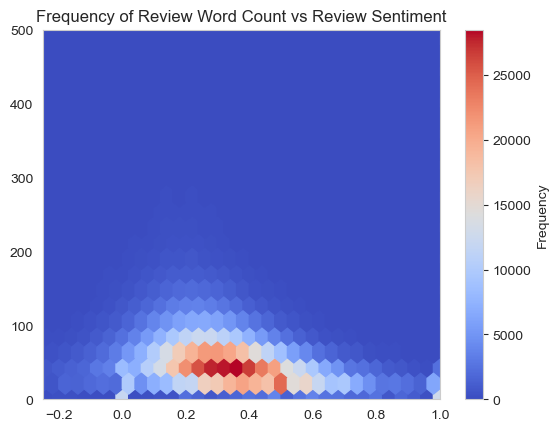

In [39]:
# Use hexbin plot to show density of previous relationship
plt.title("Frequency of Review Word Count vs Review Sentiment")
plt.hexbin(interactions["review_sentiment"], interactions["review_word_count"], gridsize=50, cmap='coolwarm')
plt.colorbar(label='Frequency')
plt.xlim([-0.25, 1.00])
plt.ylim([0, 500])
plt.show()

This shows that the shape of the previous plot is mostly determined by rare data. The majority of reviews are short and sightly positive. Here we can see the slight negative correlation suggested by the correlation coefficient as well. The pattern of the longest reviews for slightly positive sentiment is still present here.

## Conclusions and Potential Extensions

In general the dataset is quite clean, and seems to be of high quality. The minutes field in the recipes data seems to be the least reliable (or least understandable). Many of the numeric fields are correlated with one another, from original data fields as well as derived fields. The numeric fields do not seem to have any direct predictive power on rating except for review sentiment. Categorical text fields such as ingredients and tags appear to be related to ratings as well.

There is much that could be improved or extended. Notably, the variable which correlates with rating, review sentiment, could be examined over categories of ingredients and tags which are also informative. Such crosses will be examined during feature engineering.

Other improvements could include the use of more sophisticated NLP techniques on the text fields, such as n-gram analysis in descriptions and reviews or LDA to identify topics. Ingredients could potentially be clustered to reduce noise and improve the existing signal. And although nothing suggested a long-term time component influences reviews, some of the tags (e.g., "occasion", "dinner party", summer") suggest there may be an intra-year seasonality in some or all of the recipes.

In [42]:
# Export data for feature engineering and modeling
PREPROCESS_DATA_PATH = r"..\data\preprocess"
PP_RECIPES_FILE = "recipes_eda.parquet"
PP_INTERACTIONS_FILE = "interactions_eda.parquet"

pp_recipes_path = os.path.join(PREPROCESS_DATA_PATH, PP_RECIPES_FILE)
pp_interactions_path = os.path.join(PREPROCESS_DATA_PATH, PP_INTERACTIONS_FILE)

# Save DataFrame to Parquet
recipes.to_parquet(pp_recipes_path, engine="pyarrow")
interactions.to_parquet(pp_interactions_path, engine="pyarrow")